In [186]:
# Third-party Library Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon 
from unidecode import unidecode
from bias_correction import BiasCorrection
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### 1. Read SCM & ERA data

In [187]:
era_final = pd.read_csv("files/ERA/features/era_features_filtered_case11.csv")
era_raw = pd.read_csv("files/ERA/raw/era_basic_preprocessed_filtered_feature_structure_1993_2016.csv").assign(model="ERA", init_month=12)

c3s = pd.read_csv("c3s/data/c3s_hindcasts.csv")
nmme = pd.read_csv("nmme/data/nmme_hindcasts.csv")
apcc = pd.read_csv("clik-apcc/data/apcc_hindcasts.csv")
scm = pd.concat([nmme, c3s, apcc], ignore_index=True).drop_duplicates()
scm = scm.loc[(scm["year"].between(1993, 2016)) & (scm["init_month"].between(9, 11))].reset_index(drop=True)

# Store variables that are used through this notebook
climate_models = [c for c in scm.model.unique().tolist() if c != "ERA"]
crop_seasons = scm["year"].unique().tolist()
relevant_municipalities = list(set([c.split("_")[1] for c in era_final.columns if ("rain" in c) or ("tmean" in c)]))
weather_columns_final = [c for c in era_final.columns if ("rain" in c) or ("tmean" in c)]

weather_columns_raw = []
new_dict = dict(zip(["tmean", "rain"], [dict.fromkeys([c.split("_")[1] for c in weather_columns_final if ("tmean" in c)]),
                                        dict.fromkeys([c.split("_")[1] for c in weather_columns_final if ("rain" in c)])]))
for var in new_dict:
    for loc in new_dict[var]:
        new_dict[var][loc] = list(set([int(c.split("_")[-1]) for c in weather_columns_final if (var in c) and (loc in c)]))
        for month in new_dict[var][loc]:
            weather_columns_raw.append("{}_{}_{}".format(var, loc, month))

era_raw = era_raw.loc[:, ["year", "model", "init_month"] + weather_columns_raw]

# Preview
scm.sample(5)

,model,year,init_month,forecasted_month,rain,tmean,lat,lon
261025,METFR,2006,9,11,0.003178,20.939691,-35.00,-63.00
357927,CWB,2011,10,10,0.001035,11.111292,-40.00,-60.00
229869,JMA,2002,9,10,0.000777,6.269006,-27.00,-67.75
163639,DWD,1999,9,11,0.000890,11.601740,-35.00,-69.00
234445,JMA,2007,10,11,0.002722,20.842279,-33.25,-60.25


### 2. Filter SCM locations

**2.1 Obtain polygon shapes of relevant municipalities**

To forecast wheat yield in Argentina, we use weather data from two locations - Buenos Aires Coronel Dorrego and Buenos Aires Hipolito Yrigoyen. SCM data is often provided in e.g. 1° x 1° grid cells. For each location, we need to find the grid cells that are closest. 

In [188]:
# Read all polygon shapes of Argentinian municipalities
gdf_adm2 = gpd.read_file("files/shapefiles/arg_admbnda_adm2_unhcr2017.shp")[["ADM1_ES", "ADM2_ES", "geometry"]]
# Concatenate name of state and municipality
gdf_adm2["name"] = gdf_adm2[["ADM1_ES", "ADM2_ES"]].apply(lambda x: unidecode(x[0].lower()) + " " + unidecode(x[1].lower()), axis=1)
# Filter polygon shapes by the relevant municipalities
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_municipalities), ["name", "geometry"]].reset_index(drop=True)
# Convert to dictionary for easier access
name_to_shape = gdf_adm2.set_index("name")["geometry"].to_dict()
# Preview
name_to_shape

{'buenos aires coronel suarez': <POLYGON Z ((-61.603 -36.993 0, -61.735 -37.093 0, -61.735 -37.095 0, -61.73...>,
 'buenos aires hipolito yrigoyen': <POLYGON Z ((-61.45 -36.052 0, -61.435 -36.039 0, -61.393 -36.072 0, -61.333...>}

**2.2 Preview SCM locations and relevant municipality locations with buffer**

<Axes: >

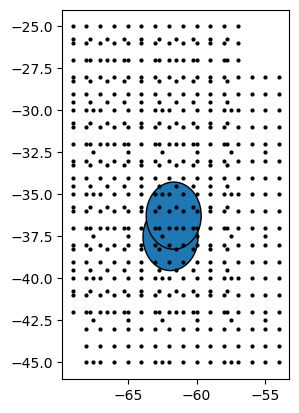

In [189]:
appc_models = ["BOM", "CWB", "HMC", "KMA", "PNU"]
c3s_models = ["CMCC", "DWD", "ECCC", "ECMWF", "JMA", "METFR", "UKMO"]
# Convert SCM dataframe to geodataframe to facilitate spatial filtering in the next section
scm = gpd.GeoDataFrame(scm, geometry=gpd.points_from_xy(scm["lon"], scm["lat"]), crs="EPSG:4326")

# Preview SCM locations and municipality polygons
base = gdf_adm2["geometry"].centroid.buffer(2).plot(edgecolor="black")
gpd.GeoDataFrame(scm.loc[:, ["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black", markersize=4)

**2.3 Filter SCM hindcasts**

For each relevant municipality, we select a grid cell location from each SCM that is closest to that municipality. If a SCM has a sparse resolution, it may be that the same grid cell is used for both locations.

In [190]:
# directly spatial join takes too much time, therefore save coordinates first
gdf_adm2["geometry"] = gdf_adm2["geometry"].centroid.buffer(2)
coordinates = gpd.sjoin(scm[["model", "geometry", "lat", "lon"]].drop_duplicates(), gdf_adm2)[["name", "lat", "lon"]].drop_duplicates().reset_index(drop=True)
scm_joined = scm.merge(coordinates[["lat", "lon", "name"]], on=["lat", "lon"], how="left")
scm_joined = scm_joined.dropna(subset="name").reset_index(drop=True)

In [191]:
coordinates

,name,lat,lon
0,buenos aires coronel suarez,-39.00,-63.00
1,buenos aires coronel suarez,-39.00,-62.00
2,buenos aires coronel suarez,-39.00,-61.00
3,buenos aires coronel suarez,-38.00,-63.00
4,buenos aires coronel suarez,-38.00,-62.00
5,buenos aires coronel suarez,-38.00,-61.00
6,buenos aires coronel suarez,-38.00,-60.00
7,buenos aires coronel suarez,-37.00,-63.00
8,buenos aires coronel suarez,-37.00,-62.00
9,buenos aires coronel suarez,-37.00,-61.00


In [192]:
filtered_scm = []
for model in climate_models:
    # Get current model and the lat-lon coordinates of its forecasts
    current_model = scm.loc[scm["model"] == model, ["model", "lat", "lon", "geometry"]].drop_duplicates()
    selected_grid_cells = []
    for count, municipality in enumerate(relevant_municipalities):
        # Get the nearest lat-lon pair to all locations (municipalities)
        grid_cell_for_current_municipality = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[municipality])[1][0]]).transpose().assign(location=municipality).reset_index(drop=True)
        selected_grid_cells.append(grid_cell_for_current_municipality)
    # Save in dataframe
    selected_grid_cells = pd.concat(selected_grid_cells, ignore_index=True)
    # The lat-lon pairs that are selected are merged with the name of their location; all other lat-lon pairs are dropped
    current_model = current_model.merge(selected_grid_cells, on=["model", "lat", "lon", "geometry"], how="left").dropna()
    # Append the locations for this model
    filtered_scm.append(current_model)        
filtered_scm = pd.concat(filtered_scm, ignore_index=True, axis=0)
scm = scm.merge(filtered_scm, on=["model", "lat", "lon", "geometry"]).dropna()
#scm["location"] = scm["location"].str.replace("buenos aires ", "")

<Axes: >

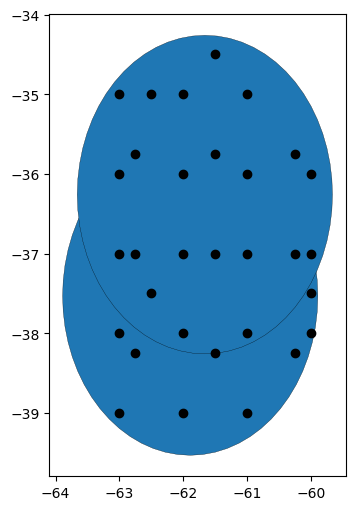

In [192]:
base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gpd.GeoDataFrame(scm_joined[["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

### 3. Bring SCM hindcasts into feature structure

In [193]:
li =[]
for m in relevant_municipalities:
    df = scm_joined.loc[(scm_joined["name"] == m)].pivot(index=["model", "year", "init_month", "lat", "lon"], columns=["name", "forecasted_month"], values=["tmean", "rain"]).reset_index()
    df.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in df.columns]
    df.columns = [c.strip("_") for c in df.columns]
    df = df.set_index(["model", "year", "init_month", "lat", "lon"])
    li.append(df)

scm_pivot_test = pd.concat(li, axis=1).reset_index().sort_values(by=["model", "year", "init_month"]).reset_index()

era_raw.columns = ["year", "model", "init_month"] + weather_columns_raw
weather_columns_raw = [c for c in era_raw.columns if ("rain" in c) or ("tmean" in c)]
scm_pivot_test = scm_pivot_test.loc[: , [c for c in scm_pivot_test.columns if c in era_raw.columns]]
scm_pivot_test.sample(3)

,model,year,init_month,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9
13407,PNU,2010,11,NaN,19.304895,NaN,0.001253,NaN
5218,ECCC,2009,10,NaN,NaN,NaN,NaN,NaN
9426,METFR,1994,9,12.146295,19.935541,0.002445,0.003408,0.002445


### 4. Adjust Bias

In [194]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """Apply bias-adjustment to monthly values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    adjusted_models = []
    for model in climate_models:
        adjusted_init_months = []
        for month in [9, 10, 11]:
            adjusted_cols = []
            for col in weather_columns_raw:
                adjusted_years = []
                for year in crop_seasons:
                    observations_used_as_reference = observed.loc[(observed["model"] == "ERA") & (observed["year"] != year), col]
                    hindcast_used_as_reference = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month), col]
                    hindcast_to_be_adjusted = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), col].copy()
                    y = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), ["model", "year", "init_month"]].copy()
                    # Perform bias-adjustment 
                    if int(col.split("_")[-1]) >= month:
                        bc_col = BiasCorrection(observations_used_as_reference, hindcast_used_as_reference, hindcast_to_be_adjusted)
                        hindcast_to_be_adjusted = bc_col.correct(method=correction_method)
                    hindcast_to_be_adjusted = pd.concat([y, hindcast_to_be_adjusted], axis=1)
                    adjusted_years.append(hindcast_to_be_adjusted)
                adjusted_years = pd.concat(adjusted_years)
                adjusted_cols.append(adjusted_years)
            adjusted_cols = pd.concat(adjusted_cols, axis=1)
            adjusted_cols = adjusted_cols.loc[:,~adjusted_cols.columns.duplicated()]
            adjusted_init_months.append(adjusted_cols)
        adjusted_init_months = pd.concat(adjusted_init_months)
        adjusted_models.append(adjusted_init_months)
    adjusted_models = pd.concat(adjusted_models).sort_values(by=["model", "year", "init_month"])
    return adjusted_models

In [195]:
scm_bias_adjusted = adjust_bias(era_raw, scm_pivot_test, "basic_quantile")
scm_bias_adjusted.sample(3)

,model,year,init_month,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9
11896,NASA,2015,11,NaN,NaN,NaN,NaN,NaN
12010,NCEP,1994,9,10.002426,17.244353,0.001218,0.002629,0.001415
5125,ECCC,2007,11,NaN,18.022065,NaN,0.002437,NaN


### 5. Standardize and Basis Expansion

Standardization is done through the LOYO-CV scheme, separately for each model.

In [196]:
def standardize_loyo(data):
    data = data.copy()
    standardized_data = []
    for model in data["model"].unique():
        standardized_data_init_month = []
        for month in data["init_month"].unique():
            standardized_data_current_scm = []
            for year in list(range(1993, 2017)):
                # split
                features_used_for_standardization = data.loc[(data["year"] != year) & (data["model"] == model) & (data["init_month"] == month), [c for c in data.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                features_to_standardize = data.loc[(data["year"] == year) & (data["model"] == model) & (data["init_month"] == month), [c for c in data.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                #print(features_used_for_standardization)
                # standardize
                features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
                # bring it together
                year_model_init_month = data.loc[(data["year"] == year) & (data["model"] == model) & (data["init_month"] == month), ["year", "model", "init_month"]].reset_index(drop=True)
                standardized_df = pd.concat([year_model_init_month, features_standardized], axis=1)
                standardized_data_current_scm.append(standardized_df)
            current_scm_standardized = pd.concat(standardized_data_current_scm, ignore_index=True)
            standardized_data_init_month.append(current_scm_standardized)
        standardized_data_init_month = pd.concat(standardized_data_init_month)
        standardized_data.append(standardized_data_init_month)
    df_standardized = pd.concat(standardized_data)
    return df_standardized

def apply_basis_expansion(data):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(data)
    df_standardized = df_standardized.sort_values(by=["model", "year", "init_month"]).set_index(["model", "year", "init_month"])
    # Store features and target in variables for better readability
    X_temp = df_standardized.loc[:, [c for c in df_standardized.columns if ("tmean" in c)]]
    X_rain = df_standardized.loc[:, [c for c in df_standardized.columns if ("rain" in c)]]
    
    tmean_loc_m = []
    for k in new_dict["tmean"].keys():
        for m in new_dict["tmean"][k]:
            tmean_loc_m.append("{}_{}".format(k,m))
    rain_loc_m = []
    for k in new_dict["rain"].keys():
        for m in new_dict["rain"][k]:
            rain_loc_m.append("{}_{}".format(k,m))
   
    tmean_rain_intersect = list(np.intersect1d(tmean_loc_m, rain_loc_m))
    
    X_rain_for_tmean = df_standardized.loc[:, ["rain_{}".format(c) for c in tmean_rain_intersect]]
    X_tmean_for_rain = df_standardized.loc[:, ["tmean_{}".format(c) for c in tmean_rain_intersect]]
    
    # basis expansion to linear model
    X_tmean_squared = X_temp.mul(X_temp)
    X_rain_squared = X_rain.mul(X_rain)
    X_rain_tmean = X_rain_for_tmean * X_tmean_for_rain.values
    X_tmean_squared.columns = ["tmeansquared_{}".format("_".join(c.split("_")[1:])) for c in X_tmean_squared.columns]
    X_rain_squared.columns = ["rainsquared_{}".format("_".join(c.split("_")[1:])) for c in X_rain_squared.columns]
    X_rain_tmean.columns = ["tmeanrain_{}".format("_".join(c.split("_")[1:])) for c in X_rain_tmean.columns]
    
    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_rain_tmean, left_index=True, right_index=True), left_index=True, right_index=True)).reset_index()

    # standardize expanded features again
    df_standardized = standardize_loyo(X)
    
    return df_standardized

In [197]:
scm_basis_expansion = apply_basis_expansion(scm_bias_adjusted)
#basis_expansion_weather_columns = [c for c in scm_basis_expansion.columns if ("tmean" in c) or ("rain" in c)]
scm_basis_expansion = scm_basis_expansion.groupby(["model", "year", "init_month"]).mean()[weather_columns_final].reset_index()
scm_basis_expansion.sample(3)

KeyboardInterrupt: 

### 6. Fill unskillful months with climatology

#### 6.1 Detect unskillful model-month forecast using out-of-sample R2

In [136]:
def r2_by_feature_init_month_and_scm(init_month, climate_models, era_df, scm_df, features):
    model_to_col_to_r2 = dict.fromkeys(climate_models)
    for model in climate_models:
        forecasted_scm = scm_df.xs(init_month, level=2, drop_level=True).xs(model, level=0, drop_level=True)[features]
        loyo_mean = (era_df[features].sum() - era_df[features]) / (era_df.shape[0] - 1)
        
        ss_total = mse(era_df[features], loyo_mean, multioutput="raw_values")
        ss_model = mse(era_df[features], forecasted_scm, multioutput="raw_values")
        
        current_r2 = 1 - ( ss_model / ss_total )
        model_to_col_to_r2[model] = dict(zip(features, current_r2))

    model_to_col_to_r2 = pd.DataFrame(model_to_col_to_r2)
    model_to_col_to_r2[model_to_col_to_r2 < 0] = np.nan
    return model_to_col_to_r2

r2_9 = r2_by_feature_init_month_and_scm(9, climate_models, era_final, scm_basis_expansion.set_index(["model", "year", "init_month"]), weather_columns_final)
r2_10 = r2_by_feature_init_month_and_scm(10, climate_models, era_final, scm_basis_expansion.set_index(["model", "year", "init_month"]), [c for c in weather_columns_final if ("_9" not in c)])
r2_11 = r2_by_feature_init_month_and_scm(11, climate_models, era_final, scm_basis_expansion.set_index(["model", "year", "init_month"]), [c for c in weather_columns_final if ("_11" in c)])

r2_by_init = r2_9.merge(r2_10.merge(r2_11, left_index=True, right_index=True, suffixes=("", "_11"), how="outer"), left_index=True, right_index=True, suffixes=("_9", "_10"), how="outer")
r2_by_init

,NASA_9,ECMWF_9,NASA_10,ECMWF_10,NASA_11,ECMWF_11
rainsquared_buenos aires hipolito yrigoyen_9,NaN,NaN,NaN,NaN,NaN,NaN
tmeanrain_buenos aires coronel suarez_11,0.178835,0.035958,NaN,0.169241,0.252240,0.341212
tmeanrain_buenos aires coronel suarez_9,NaN,NaN,NaN,NaN,NaN,NaN
tmeansquared_buenos aires coronel suarez_11,0.080208,0.081120,0.083787,0.245787,0.186425,0.164922


#### 6.2 Replace with climatology

In [169]:
init_month_to_skill = dict.fromkeys([9, 10, 11])
init_month_to_skill[9] = r2_9.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()
init_month_to_skill[10] = r2_10.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()
init_month_to_skill[11] = r2_11.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()

era_climatology = era_final.loc[:, ["year"] + weather_columns_final].set_index("year")
era_climatology = (era_climatology.sum() - era_climatology) / (era_climatology.shape[0] - 1)
era_climatology = era_climatology.reset_index()

# LOYO Climatology
era_columns_no_skill_sep = [c for c in weather_columns_final if c not in list(init_month_to_skill[9].keys())]
era_columns_no_skill_oct = [c for c in weather_columns_final if c not in list(init_month_to_skill[10].keys())]
era_columns_no_skill_nov = [c for c in weather_columns_final if c not in list(init_month_to_skill[11].keys())]

scm_filled_climatology = scm_basis_expansion.copy()
#scm_basis_expansion_climatology.xs(9, axis=0, level=1, drop_level=True).reset_index().set_index("year")[era_columns_no_skill_sep] = era_climatology[era_columns_no_skill_sep]
sep = scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 9, [c for c in scm_filled_climatology.columns if c not in era_columns_no_skill_sep]].merge(era_climatology[["year"] + era_columns_no_skill_sep], on="year")
oct = scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 10, [c for c in scm_filled_climatology.columns if c not in era_columns_no_skill_oct]].merge(era_climatology[["year"] + era_columns_no_skill_oct], on="year")
nov = scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 11, [c for c in scm_filled_climatology.columns if c not in era_columns_no_skill_nov]].merge(era_climatology[["year"] + era_columns_no_skill_nov], on="year")

scm_filled_climatology = pd.concat([sep, oct, nov], ignore_index=True, axis=0)

scm_filled_climatology.loc[(scm_filled_climatology["model"] == "NASA") & (scm_filled_climatology["init_month"] == 10), ['year', 'tmeanrain_buenos aires coronel suarez_11']].head()

,year,tmeanrain_buenos aires coronel suarez_11
49,1993,0.418060
51,1994,0.294927
53,1995,0.337330
55,1996,-0.416310
57,1997,0.108881


In [170]:
scm_basis_expansion.loc[(scm_basis_expansion["model"] == "NASA") & (scm_basis_expansion["init_month"] == 10), ['year', 'tmeanrain_buenos aires coronel suarez_11']].head()

,year,tmeanrain_buenos aires coronel suarez_11
73,1993,0.418060
76,1994,0.294927
79,1995,0.337330
82,1996,-0.416310
85,1997,0.108881


In [175]:
for im in [9, 10, 11]:
    for col in list(init_month_to_skill[im].keys()):
        scm_with_no_skill = [c for c in climate_models if c not in init_month_to_skill[im][col]]
        for model in scm_with_no_skill:
            print("{}, {}, {}".format(im, col, model))
            filter_model = scm_filled_climatology["model"] == model
            filter_init_month = scm_filled_climatology["init_month"] == im
            new_values = (era_final[col].sum() - era_final[col]) / (era_final[col].shape[0] - 1)
            new_values = new_values.values
            scm_filled_climatology.loc[(filter_model) & (filter_init_month), col] = new_values

10, tmeanrain_buenos aires coronel suarez_11, NASA


In [176]:
scm_filled_climatology.loc[(scm_filled_climatology["model"] == "NASA") & (scm_filled_climatology["init_month"] == 10), ['year', 'tmeanrain_buenos aires coronel suarez_11']].head()

,year,tmeanrain_buenos aires coronel suarez_11
49,1993,0.023029
51,1994,0.009838
53,1995,-0.052787
55,1996,-0.054087
57,1997,-0.077683


In [177]:
scm_basis_expansion.loc[(scm_basis_expansion["model"] == "NASA") & (scm_basis_expansion["init_month"] == 10), ['year', 'tmeanrain_buenos aires coronel suarez_11']].head()

,year,tmeanrain_buenos aires coronel suarez_11
73,1993,0.418060
76,1994,0.294927
79,1995,0.337330
82,1996,-0.416310
85,1997,0.108881


In [178]:
scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 9, [c for c in weather_columns_final if int(c.split("_")[-1]) < 9]] = np.nan
scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 10, [c for c in weather_columns_final if int(c.split("_")[-1]) < 10]] = np.nan
scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 11, [c for c in weather_columns_final if int(c.split("_")[-1]) < 11]] = np.nan

### 5. Fill past months with ERA data

In [179]:
scm_yield = scm_basis_expansion.merge(era_final[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")
scm_yield = scm_yield[era_final.columns].set_index("year").combine_first(era_final.set_index("year")).reset_index()
# Concat ERA with init_month = 12  
scm_era = pd.concat([scm_yield, era_final], ignore_index=True)
scm_era = scm_era.drop_duplicates().reset_index(drop=True)
scm_era = scm_era.loc[scm_era["init_month"] >= 9].sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)
# Preview
scm_era.sample(5)

,year,model,init_month,yield [kg/ha],yield anomaly [%],tmeanrain_buenos aires coronel suarez_9,tmeansquared_buenos aires coronel suarez_11,tmeanrain_buenos aires coronel suarez_11,rainsquared_buenos aires hipolito yrigoyen_9
37,2005,ECMWF,10,2652.504506,0.029549,0.425555,-0.007125,0.214440,-0.582333
18,1999,ECMWF,9,2505.600827,0.060371,0.005048,-0.178620,0.157849,-0.072098
24,2001,ECMWF,9,2275.107946,-0.083212,-0.050493,-0.258838,0.195558,-0.325743
68,2015,ECMWF,11,3101.367972,-0.032409,1.154080,-0.193485,0.388251,-0.356949
36,2005,ECMWF,9,2652.504506,0.029549,-0.348492,0.173975,0.167213,-0.467793


### 7. Analyse Bias

In [180]:
# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
scm_models = [c for c in scm_era.model.unique().tolist() if c != "ERA"]
weather_columns = [c for c in scm_era.columns if ("rain" in c) or ("tmean" in c)]

In [181]:
scm_bias = scm_era.loc[scm_era["model"].isin(scm_models)]
era_bias = scm_era.loc[scm_era["model"] == "ERA"].set_index("year")[weather_columns]

all_bias = []
for model in scm_models:
    for month in init_months:
        current_scm = scm_bias.loc[(scm_bias["model"] == model) & (scm_bias["init_month"] == month)].set_index("year")
        current_scm_bias = abs(current_scm[weather_columns] - era_bias)
        current_scm_info = current_scm[['model', 'init_month', 'yield [kg/ha]', 'yield anomaly [%]']]
        current_scm_bias.loc[:, [c for c in weather_columns if int(c.split("_")[-1]) < month]] = np.nan
        current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1).groupby(['model', 'init_month'])[weather_columns].mean().reset_index(drop=False)
        #current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1)[['model', 'init_month']+weather_columns]
        all_bias.append(current_scm)
all_bias = pd.concat(all_bias)

In [182]:
all_bias = all_bias.set_index(["model", "init_month"]).stack().reset_index()
all_bias.columns = ["model", "init_month", "feature", "bias"]

<Axes: ylabel='model'>

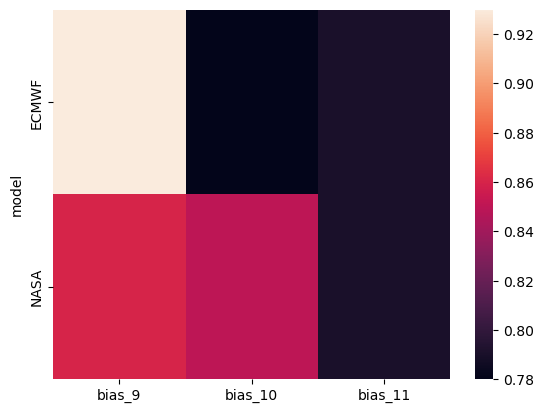

In [183]:
bias_heatmap = (all_bias.loc[(all_bias["init_month"] == 9)].groupby("model")["bias"].mean().reset_index()
                .merge(all_bias.loc[(all_bias["init_month"] == 10)].groupby("model")["bias"].mean().reset_index()
                        .merge(all_bias.loc[(all_bias["init_month"] == 11)].groupby("model")["bias"].mean().reset_index(), on="model", suffixes=("", "_11")), on="model", suffixes=("_9", "_10"))
                .round(2))
sns.heatmap(bias_heatmap.set_index("model"))

<Axes: xlabel='bias', ylabel='feature'>

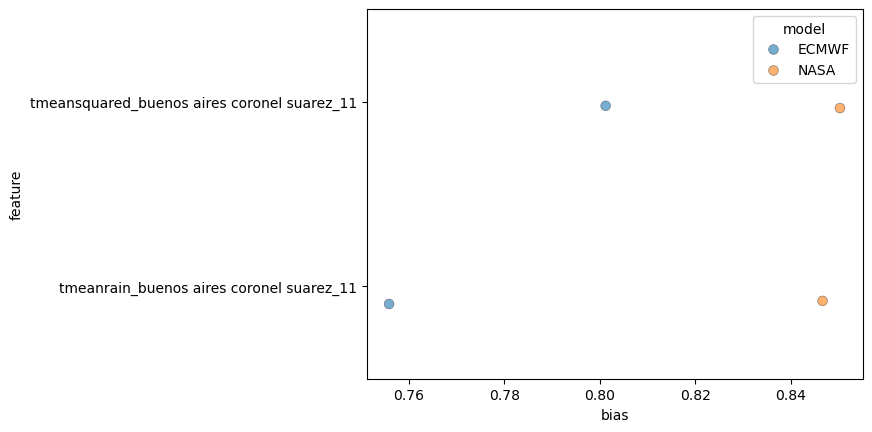

In [184]:
sns.stripplot(data=all_bias.loc[(all_bias["init_month"] == 10) & (all_bias["model"].isin(["ECMWF", "NASA"]))], x="bias", y="feature", orient="h", s=7, linewidth=0.5, alpha=.6, hue="model", jitter=True, size=(20,20))

## EXPORT

In [185]:
scm_era.to_csv("files/ERA/features/scm_era_features_filtered_case31.csv", index=False)